In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, col, isnan, count
from src.utils.s3_manager import S3Manager
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk
import os

nltk_data_dir = 'nltk_data'

if not os.path.exists(nltk_data_dir):
    os.makedirs(nltk_data_dir)
  
nltk.data.path.append(nltk_data_dir)
nltk.download('stopwords', download_dir=nltk_data_dir)

[nltk_data] Downloading package stopwords to nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

This is a simple EDA to have a better understanding of the data.
We will use Spark for loading the data and Pandas for visualization and plots

In [2]:

data_dir = "/Users/ilan/big-data-airflow-project/data"

In [3]:
spark = SparkSession.builder \
    .appName("EDA with Spark") \
    .getOrCreate()

24/05/20 13:28:26 WARN Utils: Your hostname, Ordinateur-portable-de-Ilan.local resolves to a loopback address: 127.0.0.1; using 192.168.1.18 instead (on interface en0)
24/05/20 13:28:26 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/20 13:28:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/05/20 13:28:27 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [7]:
df = spark.read.parquet(data_dir+"/NetflixDataset_preprocessed.parquet", header=True, inferSchema=True)

In [8]:
df.show(50000)

+--------------------+--------------------+------------+--------------------+-----------------+--------------------+--------------------+------+---------+---------+------+------+-----+-----------+-----+------+-------+------+--------------+------+--------+-------+
|               Title|               Genre|     Runtime|              Actors|           Rating|             Summary|                Type|Action|Adventure|Animation|Biopic|Comedy|Crime|Documentary|Drama|Horror|Famille|Guerre|MusicalRomance|Sci-Fi|Thriller|Western|
+--------------------+--------------------+------------+--------------------+-----------------+--------------------+--------------------+------+---------+---------+------+------+-----+-----------+-----+------+-------+------+--------------+------+--------+-------+
|          Ishq Vishk|   [Comedy, Romance]|     > 2 hrs|Amrita Rao, Shena...|              3.0|When the duplicit...|               Movie|     0|        0|        0|     0|     1|    0|          0|    0|     0

In [9]:
df.printSchema()

root
 |-- Title: string (nullable = true)
 |-- Genre: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- Runtime: string (nullable = true)
 |-- Actors: string (nullable = true)
 |-- Rating: double (nullable = true)
 |-- Summary: string (nullable = true)
 |-- Type: string (nullable = true)
 |-- Action: integer (nullable = true)
 |-- Adventure: integer (nullable = true)
 |-- Animation: integer (nullable = true)
 |-- Biopic: integer (nullable = true)
 |-- Comedy: integer (nullable = true)
 |-- Crime: integer (nullable = true)
 |-- Documentary: integer (nullable = true)
 |-- Drama: integer (nullable = true)
 |-- Horror: integer (nullable = true)
 |-- Famille: integer (nullable = true)
 |-- Guerre: integer (nullable = true)
 |-- MusicalRomance: integer (nullable = true)
 |-- Sci-Fi: integer (nullable = true)
 |-- Thriller: integer (nullable = true)
 |-- Western: integer (nullable = true)


In [7]:
print("The shape of the netflix dataset is ", (df.count(), len(df.columns)))

The shape of the netflix dataset is  (4297, 22)


# Dealing with missing values

We will look at each column to see how to manage missing values

In [8]:
missing_values = df.select([count(when(col(c).isNull() | isnan(c), c)).alias(c) for c in df.columns])
missing_values.show()

+-----+-----+----+---------+--------------------+-------+--------+------+------+-----------+----------+---------------+--------------------+---------+------------+--------------------+----------------+------------+-------+---------------+----------+-----+
|Title|Genre|Tags|Languages|Country Availability|Runtime|Director|Writer|Actors|View Rating|IMDb Score|Awards Received|Awards Nominated For|Boxoffice|Release Date|Netflix Release Date|Production House|Netflix Link|Summary|Series or Movie|IMDb Votes|Image|
+-----+-----+----+---------+--------------------+-------+--------+------+------+-----------+----------+---------------+--------------------+---------+------------+--------------------+----------------+------------+-------+---------------+----------+-----+
|    0|    6|  24|       21|                   8|      1|     865|   554|    19|        642|         2|           1554|                1012|     1897|          78|                   0|            1616|           0|      0|          

#### Drop Director, tags, country_availibility, writer, ViewRating, Awards Received, Awards Nominated For, BoxOffice, Netflix Release Date, Production House, Netflix Link, IMDB votes, Image columns

We will drop the columns above

In [9]:

df = df.drop(
 "Tags", 
 "Languages", 
 "Country Availability", 
 "Director", "Writer", "View Rating", "Awards Received","Awards Nominated","Boxoffice", "Netflix Release Date", "Production House", "Netflix Link", "IMDb Votes", "Image", "Awards Nominated For", "Release Date")

In [10]:
df.show()

+--------------------+--------------------+------------+--------------------+----------+--------------------+---------------+
|               Title|               Genre|     Runtime|              Actors|IMDb Score|             Summary|Series or Movie|
+--------------------+--------------------+------------+--------------------+----------+--------------------+---------------+
|          Ishq Vishk|     Comedy, Romance|     > 2 hrs|Amrita Rao, Shena...|         6|When the duplicit...|          Movie|
|          Liars Dice|Adventure, Drama,...|    1-2 hour|Vikram Bhagra, Ma...|       6.9|A woman from a sm...|          Movie|
|Reggie Yates Extreme|         Documentary|< 30 minutes|        Reggie Yates|       7.7|Award-winning fil...|         Series|
|Akashic Record of...|Animation, Action...|< 30 minutes|Josh Grelle, Moni...|       7.1|A jaded, lazy sub...|         Series|
|Its Only the End ...|               Drama|    1-2 hour|L�a Seydoux, Mari...|       6.9|A gay man returns...|         

#### Runtime column

In [11]:
df.groupby("runtime").count().orderBy("count", ascending=False).show()

+------------+-----+
|     runtime|count|
+------------+-----+
|    1-2 hour| 2509|
|< 30 minutes|  949|
|     > 2 hrs|  790|
|  30-60 mins|   48|
|        NULL|    1|
+------------+-----+


We don't want to change the runtime column, this column is already categorical.

In [12]:
df = df.fillna({'runtime': '1-2 hour'})


#### Imdb score column

Since the rating columns of allocine dataset is /5. We will normalize the rating column to be /5

In [13]:
from pyspark.sql.types import FloatType
from pyspark.sql.functions import col, round as spark_round

df = df.withColumn("IMDb Score", col("IMDb Score").cast(FloatType()))
df = df.withColumn("IMDb Score", spark_round(col("IMDb Score") / 2, 1))


In [14]:
df.show()

+--------------------+--------------------+------------+--------------------+----------+--------------------+---------------+
|               Title|               Genre|     Runtime|              Actors|IMDb Score|             Summary|Series or Movie|
+--------------------+--------------------+------------+--------------------+----------+--------------------+---------------+
|          Ishq Vishk|     Comedy, Romance|     > 2 hrs|Amrita Rao, Shena...|       3.0|When the duplicit...|          Movie|
|          Liars Dice|Adventure, Drama,...|    1-2 hour|Vikram Bhagra, Ma...|       3.5|A woman from a sm...|          Movie|
|Reggie Yates Extreme|         Documentary|< 30 minutes|        Reggie Yates|       3.8|Award-winning fil...|         Series|
|Akashic Record of...|Animation, Action...|< 30 minutes|Josh Grelle, Moni...|       3.5|A jaded, lazy sub...|         Series|
|Its Only the End ...|               Drama|    1-2 hour|L�a Seydoux, Mari...|       3.5|A gay man returns...|         

We replace each missing value by the mean of the column

In [15]:
from pyspark.sql.functions import mean

In [16]:
mean_value = df.select(mean(col("IMDb Score")).alias("mean")).collect()[0]["mean"]
df = df.na.fill({"IMDb Score": mean_value})

In [17]:
df.show()

+--------------------+--------------------+------------+--------------------+----------+--------------------+---------------+
|               Title|               Genre|     Runtime|              Actors|IMDb Score|             Summary|Series or Movie|
+--------------------+--------------------+------------+--------------------+----------+--------------------+---------------+
|          Ishq Vishk|     Comedy, Romance|     > 2 hrs|Amrita Rao, Shena...|       3.0|When the duplicit...|          Movie|
|          Liars Dice|Adventure, Drama,...|    1-2 hour|Vikram Bhagra, Ma...|       3.5|A woman from a sm...|          Movie|
|Reggie Yates Extreme|         Documentary|< 30 minutes|        Reggie Yates|       3.8|Award-winning fil...|         Series|
|Akashic Record of...|Animation, Action...|< 30 minutes|Josh Grelle, Moni...|       3.5|A jaded, lazy sub...|         Series|
|Its Only the End ...|               Drama|    1-2 hour|L�a Seydoux, Mari...|       3.5|A gay man returns...|         

#### Rename Series or Movies

In [18]:
df = df.withColumnRenamed("Series or Movie", "Type")

#### Transform each genre into a column. It's like a one hot encoding 

In [26]:
from pyspark.sql.functions import split

df = df.withColumn("Genre", split(col("Genre"), ",\s*"))
genres = ["Action", "Adventure", "Drama", "Sci-Fi", "Crime", "Thriller", "Comedy", "Biography", "Documentary"]

In [28]:
from pyspark.sql.functions import array_contains

for genre in genres:
    df = df.withColumn(genre, array_contains(col("Genre"), genre).cast("integer"))

In [29]:
df.show()

+--------------------+--------------------+------------+--------------------+----------+--------------------+------+------+---------+-----+------+-----+--------+------+---------+-----------+
|               Title|               Genre|     Runtime|              Actors|IMDb Score|             Summary|  Type|Action|Adventure|Drama|Sci-Fi|Crime|Thriller|Comedy|Biography|Documentary|
+--------------------+--------------------+------------+--------------------+----------+--------------------+------+------+---------+-----+------+-----+--------+------+---------+-----------+
|          Ishq Vishk|   [Comedy, Romance]|     > 2 hrs|Amrita Rao, Shena...|       3.0|When the duplicit...| Movie|     0|        0|    0|     0|    0|       0|     1|        0|          0|
|          Liars Dice|[Adventure, Drama...|    1-2 hour|Vikram Bhagra, Ma...|       3.5|A woman from a sm...| Movie|     0|        1|    1|     0|    0|       0|     0|        0|          0|
|Reggie Yates Extreme|       [Documentary]|< 

# Plots

For plotting, we will use pandas. We will then convert the spark dataframe to pandas dataframe.

In [30]:
pandas_df = df.toPandas() 
pandas_df.head()

,Title,Genre,Runtime,Actors,IMDb Score,Summary,Type,Action,Adventure,Drama,Sci-Fi,Crime,Thriller,Comedy,Biography,Documentary
0,Ishq Vishk,"[Comedy, Romance]",> 2 hrs,"Amrita Rao, Shenaz Treasury, Shahid Kapoor, Vi...",3.0,When the duplicitous Rajiv expresses his love ...,Movie,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,Liars Dice,"[Adventure, Drama, Family]",1-2 hour,"Vikram Bhagra, Manya Gupta, Nawazuddin Siddiqu...",3.5,A woman from a small mountain village disobeys...,Movie,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Reggie Yates Extreme,[Documentary],< 30 minutes,Reggie Yates,3.8,Award-winning filmmaker Reggie Yates travels a...,Series,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,Akashic Record of Bastard Magic Instructor,"[Animation, Action, Comedy, Fantasy]",< 30 minutes,"Josh Grelle, Monica Rial, Rachael Messer, Morg...",3.5,"A jaded, lazy substitute teacher takes over a ...",Series,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,Its Only the End of the World,[Drama],1-2 hour,"L�a Seydoux, Marion Cotillard, Vincent Cassel,...",3.5,A gay man returns to his family after a 12-yea...,Movie,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


/var/folders/bg/rn6v3_d90s7b47lrzgg2ds0c0000gn/T/ipykernel_17007/3926704042.py:1 FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

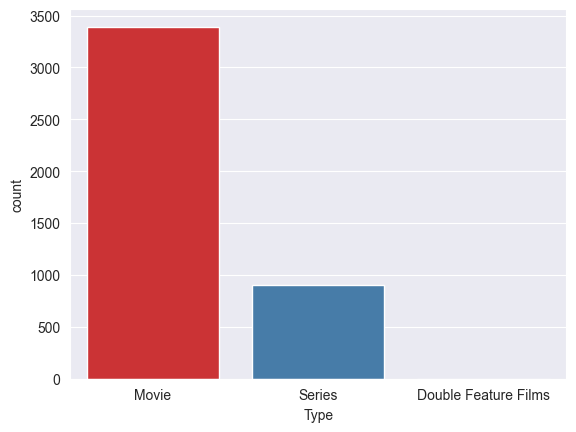

In [31]:
ax = sns.countplot(x="Type", data=pandas_df, palette="Set1")

### ImdB Score distribution

[2024-05-19T13:36:47.519+0200] {category.py:223} INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


/var/folders/bg/rn6v3_d90s7b47lrzgg2ds0c0000gn/T/ipykernel_17007/177316272.py:2 FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

[2024-05-19T13:36:47.532+0200] {category.py:223} INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


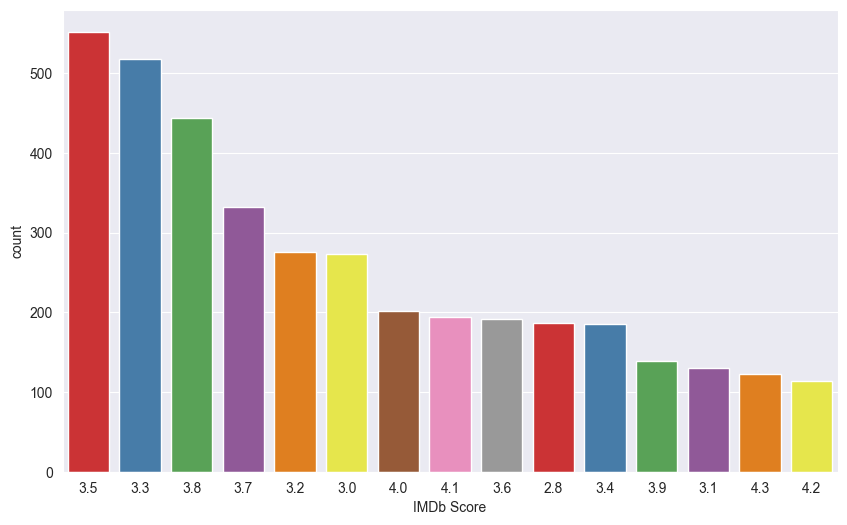

In [32]:
plt.figure(figsize=(10,6))
sns.countplot(x="IMDb Score", legend=False,data=pandas_df, palette="Set1",  order=pandas_df['IMDb Score'].value_counts().index[0:15])
plt.show()

## EDA NLP

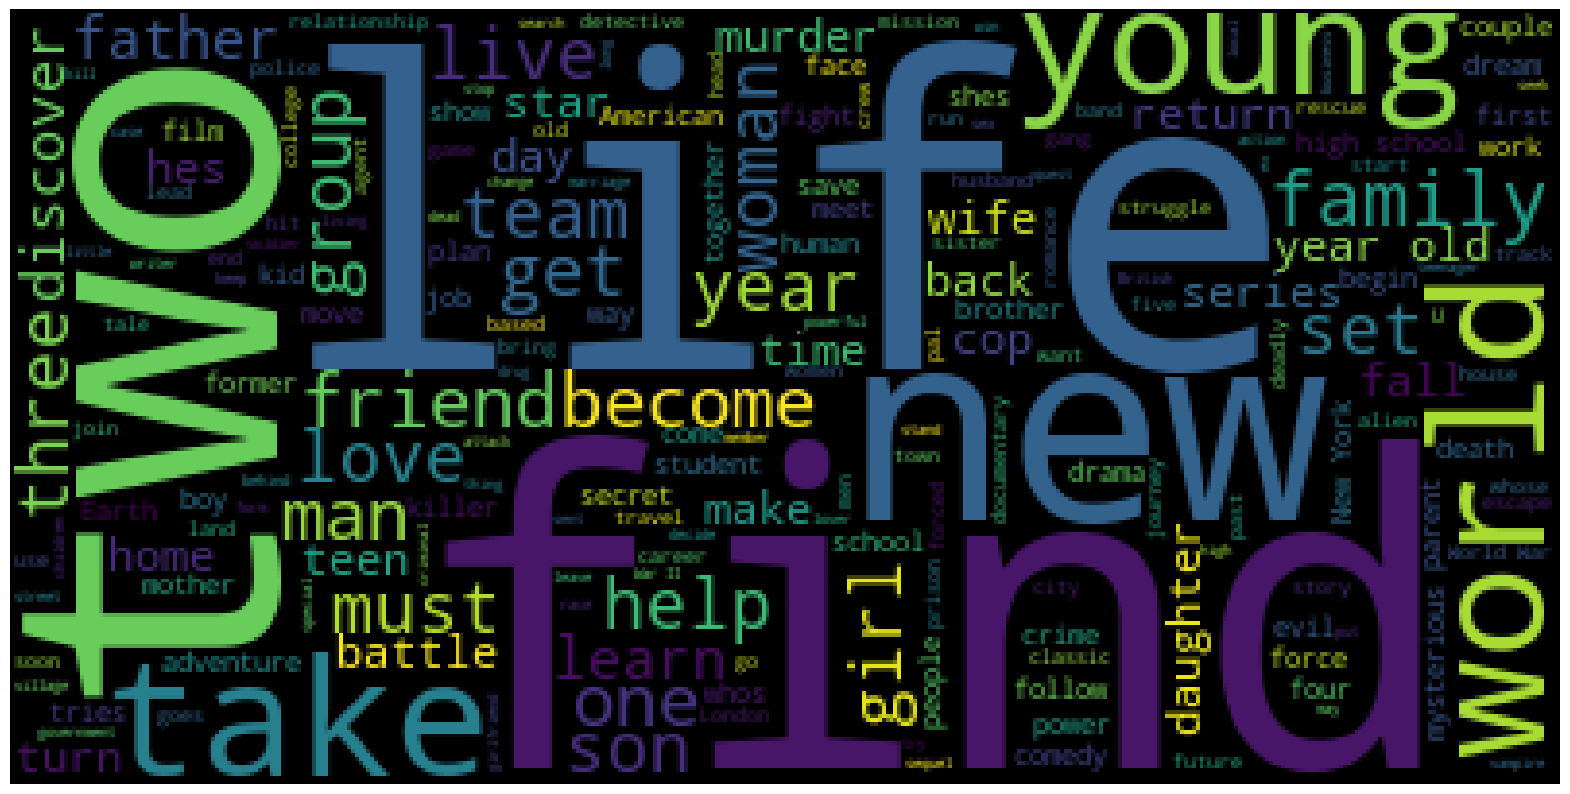

In [33]:
stop_words = set(stopwords.words('english'))
plt.figure(figsize=(20,20))
wordcloud = WordCloud(background_color = 'black', stopwords = stop_words).generate(" ".join(pandas_df.Summary))

plt.imshow(wordcloud)
plt.axis("off")
plt.show();

+--------------------+-----+
|               Genre|count|
+--------------------+-----+
|            [Comedy]|  278|
|             [Drama]|  202|
|[Comedy, Drama, R...|  152|
|   [Comedy, Romance]|  128|
|    [Drama, Romance]|  121|
|     [Comedy, Drama]|  102|
|[Action, Crime, T...|   94|
|       [Documentary]|   82|
|[Crime, Drama, Th...|   67|
|[Action, Crime, D...|   62|
|[Crime, Drama, My...|   58|
|      [Crime, Drama]|   49|
|[Horror, Mystery,...|   45|
|   [Drama, Thriller]|   43|
|[Action, Adventur...|   42|
|  [Action, Thriller]|   37|
|  [Biography, Drama]|   33|
|[Documentary, Com...|   32|
|[Animation, Adven...|   32|
|[Action, Adventur...|   29|
+--------------------+-----+


In [14]:
df1 = spark.read.parquet(data_dir+"/NetflixDataset_preprocessed.parquet", header=True, inferSchema=True)
df2 = spark.read.parquet(data_dir+"/allocine_movies_preprocessed.parquet", header=True, inferSchema=True)

In [15]:
df2_reordered = df2.select(df1.columns)

        # Combine the two dataframes
combined_df = df1.union(df2_reordered)

In [16]:
combined_df.show()

+--------------------+------------+--------------------+------+--------------------+------+------+---------+---------+------+------+-----+-----------+-----+------+-------+------+--------------+------+--------+-------+
|               Title|     Runtime|              Actors|Rating|             Summary|  Type|Action|Adventure|Animation|Biopic|Comedy|Crime|Documentary|Drama|Horror|Famille|Guerre|MusicalRomance|Sci-Fi|Thriller|Western|
+--------------------+------------+--------------------+------+--------------------+------+------+---------+---------+------+------+-----+-----------+-----+------+-------+------+--------------+------+--------+-------+
|          Ishq Vishk|     > 2 hrs|Amrita Rao, Shena...|   3.0|When the duplicit...| Movie|     0|        0|        0|     0|     1|    0|          0|    0|     0|      0|     0|             0|     0|       0|      0|
|          Liars Dice|    1-2 hour|Vikram Bhagra, Ma...|   3.5|A woman from a sm...| Movie|     0|        1|        0|     0|   